Notes to self
This is tempermental to module version
Use base conda env on MacBook Pro laptop

In [13]:
# --------------------------------------------------- #
# Specific version for current Scarlet2               #
# run this is having issue with commands not existing #
# make a standalone conda env for now, fix later      #
# --------------------------------------------------- #
## uninstall current versions of jax, jaxlib, diffrax, equinox

# un-comment below here and run cell
# import time
# !pip uninstall jax -y
# !pip uninstall diffrax -y
# !pip uninstall equinox -y
# !pip uninstall jaxlib -y

# # now install correct versions
# !pip install diffrax==0.2.0
# time.sleep(5)
# !pip install equinox==0.8.0
# time.sleep(5)
# !pip install jaxlib==0.3.20
# time.sleep(5)
# !pip install jax==0.3.22
# !pip install galaxygrad # - library with trained nn weights

In [14]:
# specify to reload any packages that are changed
# helps with not having to restart the kernel each time
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [15]:
import numpy as np
import jax.numpy as jnp
import equinox as eqx
from jax import random, jit
import distrax
import matplotlib.pyplot as plt
from scarlet2 import *
import optax
from tqdm.auto import tqdm
import warnings
warnings.filterwarnings("ignore") # suppress version depreciation warnings of jax.tree_structure 

In [16]:
file = np.load("hsc_cosmos_35.npz")
data = file["images"]
weights = 1/file["variance"]
psf = file["psfs"]
centers = jnp.asarray( [(src['y'], src['x']) for src in file["catalog"]] )
obs = Observation(data, weights, psf=ArrayPSF(jnp.asarray(psf)))
frame_psf = GaussianPSF(jnp.array((0, 0.2)), 0.7)
model_frame = Frame(Box(data.shape), psf=frame_psf)
obs.match(model_frame);

In [17]:
# try to mess around getting prior to work
# TODO: determine best way to ensure prior is being used
# TODO: make sure the box size is determined correctly, not explicitly set
arr_size = 20

keys = random.split(random.PRNGKey(0), 2)
with Scene(model_frame) as scene:
    for i in range(len( centers )):
        Source(
            centers[i],
            ArraySpectrum(random.normal(keys[0], (5,)), constraint=PositiveConstraint()),
            ArrayMorphology(random.normal(keys[1], (arr_size, arr_size)), prior=NNPrior())
        )

sources_init = scene()

In [18]:
# TODO: fix "jax.tree_structure" is deprecated so we can use latest jax and equinox
# TODO: fix the non-hashable item in Observation class so we can use jit
# NOTE: Currently for 7 srcs and 20x20 array, takes ~ 1 min to run 1500 steps on my M1 MacBookPro

@eqx.filter_value_and_grad
def loss_fn_with_grad(model, obs):
    sources = model()
    neg_log_like = -obs.log_likelihood(sources)
    return neg_log_like - model.log_prior()

#@eqx.filter_jit
# TODO: Hash error when using jit in the Observation class -- think I need to convert tuple to list?
def make_step(model, obs, opt_state):
    loss, grads = loss_fn_with_grad(model, obs)
    updates, opt_state = optim.update(grads, opt_state)
    model = eqx.apply_updates(model, updates)
    return loss, grads, model, opt_state


learning_rate=1e-1
optim = optax.adam(learning_rate)
opt_state = optim.init(eqx.filter(scene, eqx.is_array))

pbar = tqdm(range(1500), desc='')
for step in pbar:
    loss, grads, scene, opt_state = make_step(scene, obs, opt_state)
    loss = loss.item()
    pbar.set_description(f" fitting sources ==>  step: {step} loss: {loss}")
print(f"final step={step} loss={loss}")

  0%|          | 0/1500 [00:00<?, ?it/s]

final step=1499 loss=20244.12109375


In [19]:
#T TODO: ArrayMorphology shows the nn prior but not using it
print( scene.sources )

[Source(
  spectrum=ArraySpectrum(
    value=f32[5],
    constraint=<scarlet2.constraint.PositiveConstraint object at 0x16a7fa700>,
    prior=None,
    fixed=False,
    bbox=Box(shape=(5,), origin=(0,))
  ),
  morphology=ArrayMorphology(
    value=f32[20,20],
    constraint=None,
    prior=<scarlet2.nn.NNPrior object at 0x176e21580>,
    fixed=False,
    bbox=Box(shape=(20, 20), origin=(23, 4)),
    center=Parameter(value=f32[2], constraint=None, prior=None, fixed=True)
  )
), Source(
  spectrum=ArraySpectrum(
    value=f32[5],
    constraint=<scarlet2.constraint.PositiveConstraint object at 0x15e8e88b0>,
    prior=None,
    fixed=False,
    bbox=Box(shape=(5,), origin=(0,))
  ),
  morphology=ArrayMorphology(
    value=f32[20,20],
    constraint=None,
    prior=<scarlet2.nn.NNPrior object at 0x110c6cb80>,
    fixed=False,
    bbox=Box(shape=(20, 20), origin=(26, 21)),
    center=Parameter(value=f32[2], constraint=None, prior=None, fixed=True)
  )
), Source(
  spectrum=ArraySpectrum(
  

In [20]:
# TODO: find out why grads don't show prior in ArrayMorphology, is this expected?
print( grads.sources )

[Source(
  spectrum=ArraySpectrum(
    value=f32[5],
    constraint=None,
    prior=None,
    fixed=None,
    bbox=Box(shape=(5,), origin=(0,))
  ),
  morphology=ArrayMorphology(
    value=f32[20,20],
    constraint=None,
    prior=None,
    fixed=None,
    bbox=Box(shape=(20, 20), origin=(23, 4)),
    center=Parameter(value=f32[2], constraint=None, prior=None, fixed=None)
  )
), Source(
  spectrum=ArraySpectrum(
    value=f32[5],
    constraint=None,
    prior=None,
    fixed=None,
    bbox=Box(shape=(5,), origin=(0,))
  ),
  morphology=ArrayMorphology(
    value=f32[20,20],
    constraint=None,
    prior=None,
    fixed=None,
    bbox=Box(shape=(20, 20), origin=(26, 21)),
    center=Parameter(value=f32[2], constraint=None, prior=None, fixed=None)
  )
), Source(
  spectrum=ArraySpectrum(
    value=f32[5],
    constraint=None,
    prior=None,
    fixed=None,
    bbox=Box(shape=(5,), origin=(0,))
  ),
  morphology=ArrayMorphology(
    value=f32[20,20],
    constraint=None,
    prior=Non

In [21]:
# test to see if issue is with image storage type
# NOTE: nope works fine. grads correctly calculated, but not with the log_prior routine
# import jax

# src = scene()
# y = src[0]
# dim_1_start = int(centers[0] - arr_size/2)
# dim_1_end   = int(centers[0] + arr_size/2)
# dim_2_start = int(centers[1] - arr_size/2)
# dim_2_end   = int(centers[1] + arr_size/2)
# y = y[dim_1_start:dim_1_end, dim_2_start:dim_2_end]
# nn = NNPrior()
# grads_init = jax.grad(nn.log_prob)(y)
# #grads_init = jax.grad( scene.log_prior )(x) # Doesn't work

# tmax = np.max(np.abs(grads_init))
# fig, axs = plt.subplots(1,2,figsize=(9,9), dpi = 100)
# axs[0].imshow(y,cmap = 'hot')
# axs[1].imshow(grads_init,cmap = 'seismic', vmin = -tmax, vmax = tmax)

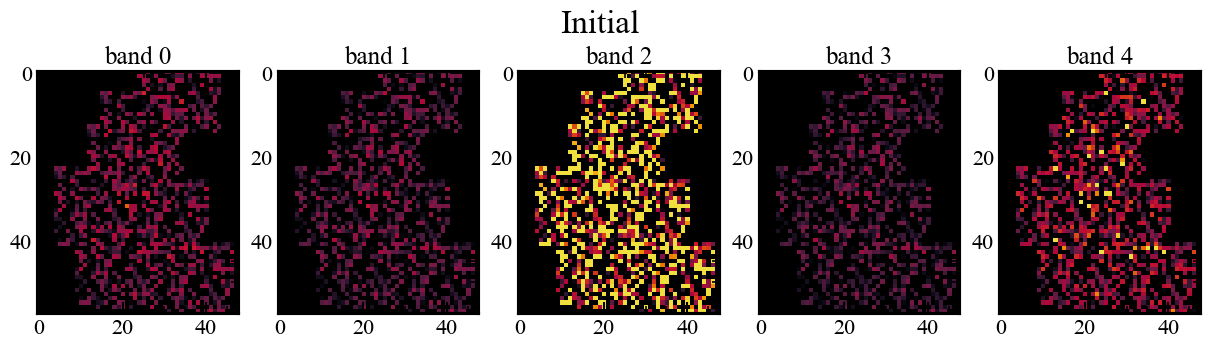

In [66]:
import cmasher as cmr
# TODO: Make proper normalising and stretching routine like the Lupton one
from astropy.visualization.stretch import SinhStretch, LinearStretch
from astropy.visualization import ImageNormalize
stretch = LinearStretch(slope=0.5, intercept=0.5) + SinhStretch() + \
    LinearStretch(slope=1, intercept=-1)
norm = ImageNormalize(stretch=stretch, vmin=0, vmax=5)

# create some plots to see how the sources look
sources = scene()

fig, axes = plt.subplots(1, sources.shape[0], figsize=(15,6),dpi=100)
for i, ax in enumerate(axes):
    ax.imshow(sources_init[i], cmap = cmr.ember, norm=norm)
    ax.set_title(f"band {i}", fontsize = 18)
plt.suptitle('Initial', fontsize=24,y=0.8)
plt.show()


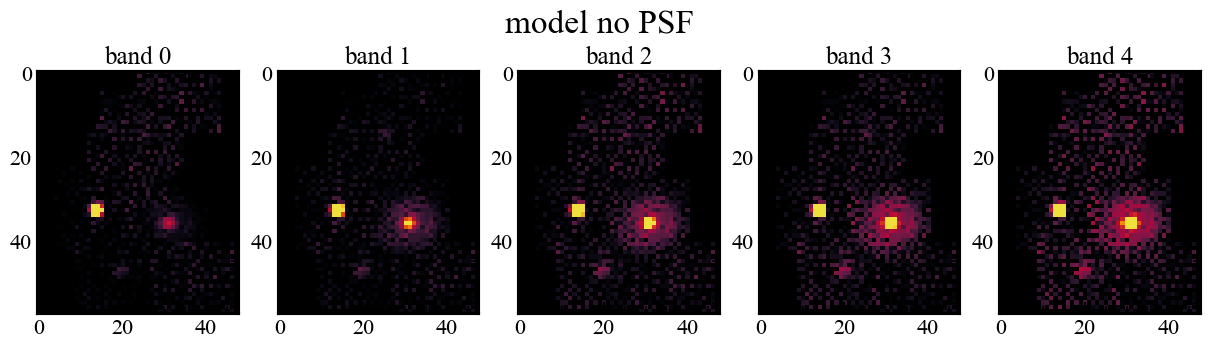

In [67]:
fig, axes = plt.subplots(1, sources.shape[0], figsize=(15,6),dpi=100)
for i, ax in enumerate(axes):
    ax.imshow(sources[i], cmap = cmr.ember, norm=norm)
    ax.set_title(f"band {i}", fontsize = 18)
plt.suptitle('model no PSF', fontsize=24,y=0.8)
plt.show()

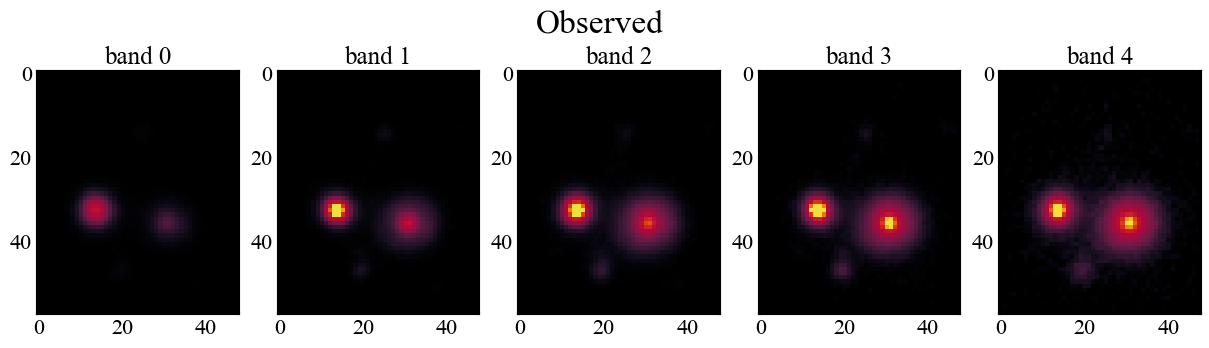

In [68]:
fig, axes = plt.subplots(1, sources.shape[0], figsize=(15,6),dpi=100)
for i, ax in enumerate(axes):
    ax.imshow(obs.data[i], cmap = cmr.ember,norm=norm)
    ax.set_title(f"band {i}", fontsize = 18)
plt.suptitle('Observed', fontsize=24,y=0.8)
plt.show()